In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# SERVOMECANISMO COM INTEGRADOR

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [3]:
s = ctl.TransferFunction.s

G     = 1/(s*(s+1)*(s+2))
G_bkp = G
G

TransferFunction(array([1]), array([1, 3, 2, 0]))

polos:  (-2+0j) (-1+0j) 0j
zeros: 


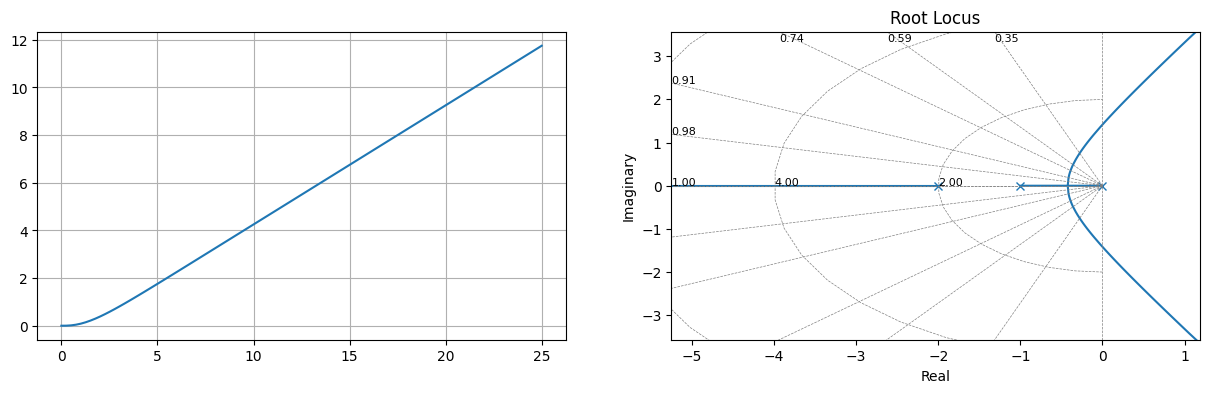

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

In [5]:
Ts = 2.50
UP = 0.20

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.4559498107691261

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

3.509158162169242

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 2) for val in [s1, s2, s3, s4, s5]]
p

[(-1.6+3.12j), (-1.6-3.12j), -5, -5, -5]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [9]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-3.0, -2.0, 0],
[ 1.0,    0, 0],
[   0,  1.0, 0]])

Matrix([
[1.0],
[  0],
[  0]])

Matrix([[0, 0, 1.0]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [10]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

display(A)
display(B)
display(C)
display(D)

Matrix([
[0,  1.0,    0],
[0,    0,  1.0],
[0, -2.0, -3.0]])

Matrix([
[  0],
[  0],
[1.0]])

Matrix([[1.0, 0, 0]])

Matrix([[0]])

In [11]:
n = sp.shape(A)[0]
n

3

# CONTROLADOR

In [12]:
Ahat = sp.Matrix([
    [A,  sp.zeros(n, 1)],
    [-C, sp.zeros(1, 1)]
])

Bhat = sp.Matrix([
    [B],
    [sp.zeros(1, 1)]
])

Chat = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

Dhat = D

display(Ahat)
display(Bhat)
display(Chat)
display(Dhat)

Matrix([
[   0,  1.0,    0, 0],
[   0,    0,  1.0, 0],
[   0, -2.0, -3.0, 0],
[-1.0,    0,    0, 0]])

Matrix([
[  0],
[  0],
[1.0],
[  0]])

Matrix([[1.0, 0, 0, 0]])

Matrix([[0]])

In [13]:
K = ctl.acker(Ahat, Bhat, p)
#K = ctl.place(A, B, p)

Ki = -1 * K[0][-1]
K  = np.array([K[0][:-1]]) # desconsiderando o últomo elemento que é o Ki

print(Ki)
sp.Matrix(K)

1536.8000000000002


Matrix([[1322.08, 519.016, 87.6944]])

In [14]:
s = sp.symbols('s')
I = sp.eye(n+1) 
K = sp.Matrix(K)

In [15]:
A_new = sp.Matrix([
    [A - B*K, B*Ki],
    [-C, sp.zeros(1, 1)]
])

B_new = sp.Matrix([
    [sp.zeros(n, 1)],
    [1]
])

C_new = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

D_new = D

display(A_new)
display(B_new)
display(C_new)
display(D_new)

Matrix([
[       0,      1.0,        0,      0],
[       0,        0,      1.0,      0],
[-1322.08, -521.016, -90.6944, 1536.8],
[    -1.0,        0,        0,      0]])

Matrix([
[0],
[0],
[0],
[1]])

Matrix([[1.0, 0, 0, 0]])

Matrix([[0]])

- Obtendo toda a função de transferência: $T_F = \frac{Y(s)}{U(s)} = C(sI - A)^{-1}B + D$

In [16]:
T = C_new * (s*I - A_new).inv() * B_new + D_new
T = T[0]
T

1.0*(-0.0625*s**2 - 0.125*s + 729180327569540.0)/(474479650943.22*s**4 + 43032647254504.7*s**3 + 247211489815833.0*s**2 + 627300056919012.0*s + 729180327569540.0)

In [17]:
G = sympyFunction(G)
G

1/(s**3 + 3*s**2 + 2*s)

- O controlador C é obtido usando a relação $T(s) = \frac{G(s)C(s)}{1 + C(s)C(s)}$

In [18]:
C = T/(G*(1 - T))
C = C.expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(0.0006*s**6 + 0.0565*s**5 + 0.4794*s**4 + 1.8491*s**3 + 3.9467*s**2 + 4.3745*s + 1.8534)/(0.0001*s**6 + 0.0036*s**5 + 0.0381*s**4 + 0.2012*s**3 + 0.5952*s**2 + 1.0*s + 0.7972)

# RESPOSTA CONTROLADA

In [19]:
s = ctl.TransferFunction.s
C = eval(str(C))
G = G_bkp

In [20]:
G_ma = G*C
G_ma

TransferFunction(array([6.0000e-04, 5.6500e-02, 4.7940e-01, 1.8491e+00, 3.9467e+00,
       4.3745e+00, 1.8534e+00]), array([1.0000e-04, 3.9000e-03, 4.9100e-02, 3.2270e-01, 1.2750e+00,
       3.1880e+00, 4.9876e+00, 4.3916e+00, 1.5944e+00, 0.0000e+00]))

In [21]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([6.0000e-04, 5.6500e-02, 4.7940e-01, 1.8491e+00, 3.9467e+00,
       4.3745e+00, 1.8534e+00]), array([1.0000e-04, 3.9000e-03, 4.9100e-02, 3.2330e-01, 1.3315e+00,
       3.6674e+00, 6.8367e+00, 8.3383e+00, 5.9689e+00, 1.8534e+00]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [22]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-22.558+0j),
 (-4.939+0j),
 (-1.334+2.101j),
 (-1.334-2.101j),
 (-1.786+1.652j),
 (-1.786-1.652j),
 (-2.219+0j),
 (-2.045+0j),
 (-1+0j)]

polos:  (-22.558+0j) (-4.939+0j) (-1.334+2.101j) (-1.334-2.101j) (-1.786+1.652j) (-1.786-1.652j) (-2.219+0j) (-2.045+0j) (-1+0j)
zeros:  (-85.203+0j) (-1.596+1.997j) (-1.596-1.997j) (-2.767+0j) (-2.005+0j) (-1+0j)


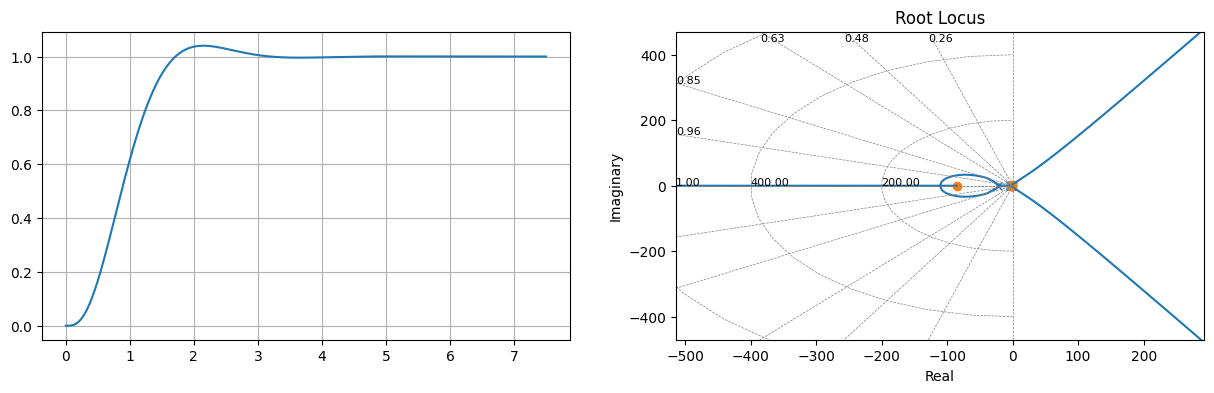

In [23]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G_feedback, T=np.linspace(0, 3*Ts, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [24]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.040176895682440435
valor de pico:  1.040174790248311
tempo de pico:  2.1471471471471473
tempo de assentamento:  2.6726726726726726
valor final:  0.9999979758883915
erro:  2.0241116085450983e-06


# APLICANDO VÁRIOS STEPS

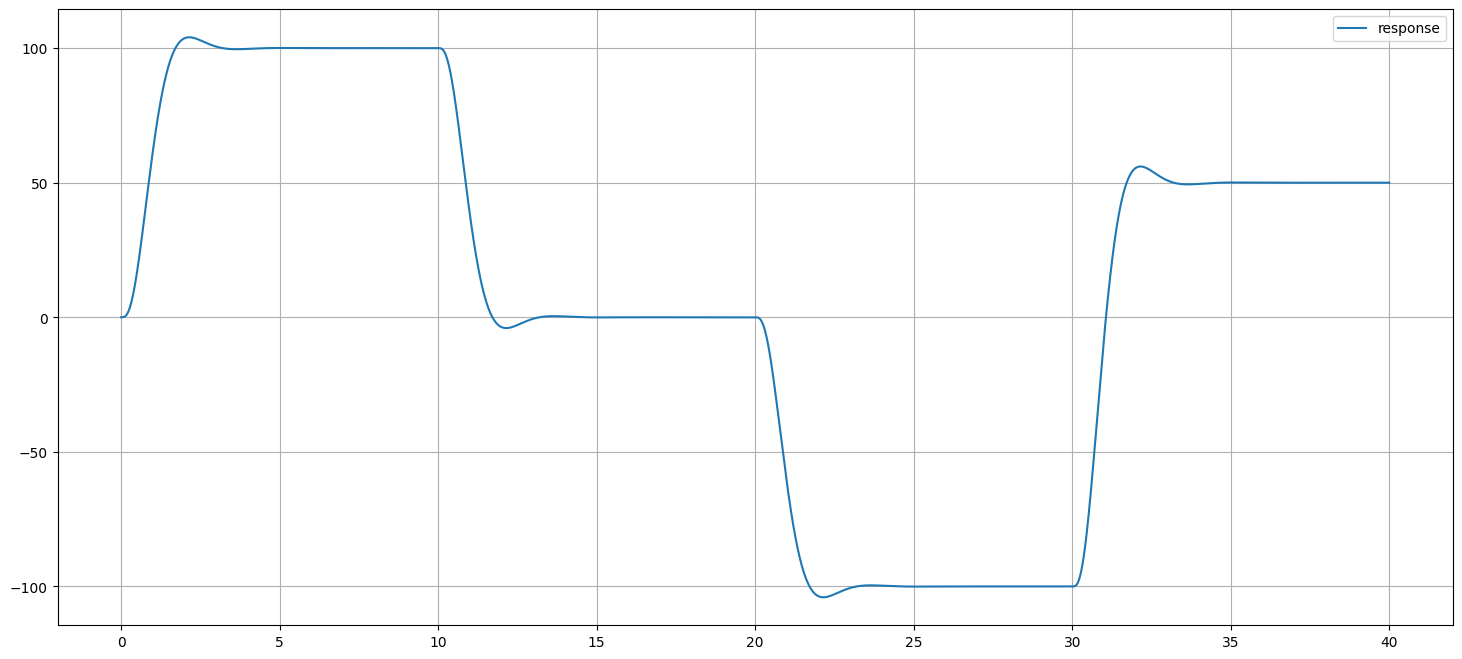

In [ ]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()